# Tutorial 2: Intermediate level
Using esinet to predict single time-frame sources of a sample ERF data set: The Brainstorm Auditory data. 

This tutorial is based on an [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
import os

subjects_dir = mne.datasets.sample.data_path() + '\\subjects'
plot_params = dict(surface='white', hemi='both', verbose=0, subjects_dir=subjects_dir)
mne.set_config('SUBJECTS_DIR', subjects_dir)

C:\Users\Lukas\AppData\Local\Temp/ipykernel_9396/3013441672.py:15: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  subjects_dir = mne.datasets.sample.data_path() + '\\subjects'


# Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [2]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',  
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
# raw.info['bads'] = ['MEG 2443', 'EEG 053']  # no bad channels with EEG
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, eog=150e-6)  # , mag=4e-12

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('grad', 'eog'), baseline=baseline, reject=reject,  # grad instead of meg
                    verbose=0, preload=True)

epochs.drop_channels('EOG 061')
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif' 
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg=True) # instead of meg=True
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


C:\Users\Lukas\AppData\Local\Temp/ipykernel_9396/1977049674.py:20: DeprecationWarning: data_path functions now return pathlib.Path objects which do not natively support the plus (+) operator, switch to using forward slash (/) instead. Support for plus will be removed in 1.2.
  fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'


## Visualize the sample data

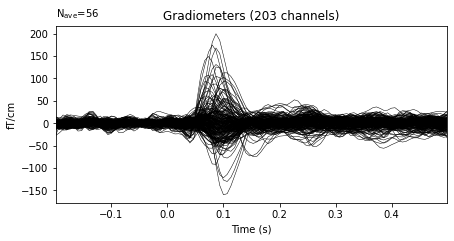

Number of events,56
Events,aud_l: 56
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


In [3]:
epochs.average().plot(verbose=0)
epochs

# Simulate Data
Artificial neural networks need training data to learn how to predict brain-electric activity (sources) given the M/EEG data. 

First, we calculate the signal to noise ratio (SNR) of our EEG data so we can adjust our simulations to it. 

In [4]:
target_snr = util.calc_snr_range(epochs, baseline_span=(-0.2, 0.0), data_span=(0.05, 0.2))
print(f'The target SNR is {target_snr:.2f}')

The target SNR is 4.58


c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\util\util.py:222: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199795 sec)
  data_base = evoked.copy().crop(*baseline_span)._data


Next, we can perform the simulations with the packages default settings. Change n_samples to a smaller integer in case this cell runs for too long. Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,00.

In [5]:
settings = dict(duration_of_trial=0.2, target_snr=target_snr)
n_samples = 1000
simulation = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation.simulate(n_samples=n_samples)

c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\simulation.py:646: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 1000/1000 [00:19<00:00, 52.58it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 1000/1000 [00:00<00:00, 1626.15it/s]


source data shape:  (7498, 30) (7498, 30)

Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 1000/1000 [00:13<00:00, 73.03it/s]



Convert EEG matrices to a single instance of mne.Epochs...


## Visualize the simulated data
Let's visualize the simulated data and see if it looks alright. You can change the idx to another integer to visualize a different sample

In [6]:
%matplotlib qt
idx = 0

simulation.eeg_data[idx].average().plot_topomap([0.])
simulation.source_data[idx].plot(**plot_params, initial_time=simulation.source_data[idx].times[idx], time_viewer=False)

# Train the Neural Network
The Net class contains our neural network.

Using the simulations created above, we can train the neural network. This may take a few minutes, depending on your PC.
For best results you should increase the number of epochs to 100 or more.  

In [7]:
model_type = 'FC'  # can be 'LSTM' or 'ConvDip', too
net = Net(fwd, verbose=1, model_type='FC')  # Initialize the neural network object
net.fit(simulation, epochs=10)  # Train the net using our simulated eeg and source data.

preprocess data
wrks4
Model: "FC-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FC_0 (TimeDistributed)      (None, None, 200)         40800     
                                                                 
 Drop_0 (Dropout)            (None, None, 200)         0         
                                                                 
 FC_Out (TimeDistributed)    (None, None, 7498)        1507098   
                                                                 
Total params: 1,547,898
Trainable params: 1,547,898
Non-trainable params: 0
_________________________________________________________________
fit model
Epoch 1/10
112/112 [==============================] - 2s 11ms/step - loss: -0.2095 - mae: 0.0791 - val_loss: -0.3017 - val_mae: 0.0789
Epoch 2/10
112/112 [==============================] - 2s 9ms/step - loss: -0.3056 - mae: 0.0795 - val_loss: -0.3331 - val_mae: 0.0762
Epoch 3/10


# Evaluate the ANN
The evaluation is a two-step procedure. 
1. Simulate some test data which the neural network has not seen yet. Unlike 
   the training data, this simulated data will also have a temporal dimension, 
   as indicated by the "duration_of_trial" parameter.

2. Perform predicions on this data and visually examine the results.

In [8]:
settings = dict(duration_of_trial=1, target_snr=target_snr, number_of_sources=(1, 10), extents=(2, 40),)
n_samples = 10
simulation_test = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation_test.simulate(n_samples=n_samples)


# Predict source from EEG
source_hat = net.predict(simulation_test)

c:\Users\Lukas\Documents\projects\esinet\tutorials\..\esinet\simulation.py:646: RuntimeWarning: 8.5% of original source space vertices have been omitted, tri-based adjacency will have holes.
Consider using distance-based adjacency or morphing data to all source space vertices.
  adj = mne.spatial_src_adjacency(self.fwd["src"], verbose=0).toarray().astype(int)


Simulate Source
Simulating data based on sparse patches.


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Converting Source Data to mne.SourceEstimate object


100%|██████████| 10/10 [00:00<00:00, 303.85it/s]


source data shape:  (7498, 150) (7498, 150)

Project sources to EEG...

Create EEG trials with noise...


100%|██████████| 10/10 [00:00<00:00, 18.40it/s]



Convert EEG matrices to a single instance of mne.Epochs...


c:\Users\Lukas\Envs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Visualize a sample

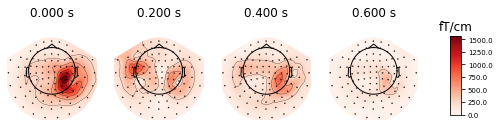

In [9]:
%matplotlib qt

# Ground Truth
idx = 0
source = simulation_test.source_data[idx]
# Plot simulated Source
a = source.plot(**plot_params)
a.add_text(0.1, 0.9, 'Gound Truth', 'title',
               font_size=14)
# Plot simulated EEG
evoked = simulation_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap([0.0, 0.2, 0.4, 0.6])

# Plot esinet prediction
b = source_hat[idx].plot(**plot_params)
b.add_text(0.1, 0.9, 'Prediction', 'title',
               font_size=14)

# Plot predicted EEG
evoked_hat = util.get_eeg_from_source(source_hat[idx], fwd, epochs_stripped.info, tmin=-0.2)
evoked_hat.plot()
evoked_hat.plot_topomap([0.0, 0.2, 0.4, 0.6])

# Estimate sources from real data
Using ANN

c:\Users\Lukas\Envs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


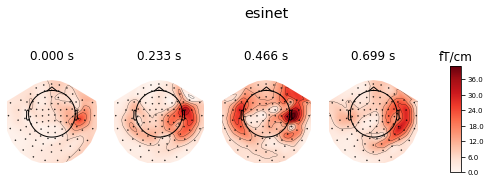

In [10]:
# Predict Source
stc = net.predict(epochs.average())[0]
# Plot Predicted Source
brain = stc.plot(**plot_params)
brain.add_text(0.1, 0.9, 'esinet on Auditory Data', 'title',
               font_size=14)
# Plot true EEG
epochs.load_data()

epochs.pick_types(meg=True).average().plot()
epochs.pick_types(meg=True).average().plot_topomap(title='True')

# Plot predicted EEG
evoked_esi = util.get_eeg_from_source(stc, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_esi.plot()
evoked_esi.plot_topomap(title='esinet')


...using eLORETA

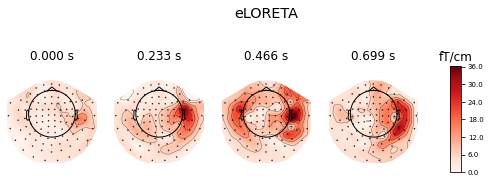

In [11]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=False)

inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked.info, fwd, noise_cov, loose='auto', depth=None, fixed=True, 
    verbose=False)
    
stc_elor, residual = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2,
                              method=method, return_residual=True, verbose=False)
brain = np.abs(stc_elor).plot(**plot_params)
brain.add_text(0.1, 0.9, 'eLORETA on auditory data', 'title',
               font_size=14)
# Plot predicted EEG
epochs.load_data()
evoked_elor = util.get_eeg_from_source(stc_elor, fwd, epochs.pick_types(meg=True).info, tmin=0.)
evoked_elor.plot()
evoked_elor.plot_topomap(title='eLORETA')
